In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

In [ ]:
address = 'Halles, Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

In [ ]:
import folium
import json

geo = json.load(open("../quartier_paris.geojson"))

centre = [48.86, 2.35]
carte = folium.Map(location = centre, zoom_start = 12)
carte.choropleth(geo_data = geo)
carte

In [ ]:
CLIENT_ID = 'YCVQZPRAJ1UO23NC4AN4LYVKDIYSAEMZYU4QYFCMUVQ4KU1J' # your Foursquare ID
CLIENT_SECRET = 'Q1JKTI4MG3MQKM1SBUFOMPSUU14H0GCYMUJXF2Y2E3AYN1EU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:

LIMIT = 500 # limit of number of venues returned by Foursquare API
neighborhood_latitude = latitude
neighborhood_longitude = longitude

radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

In [ ]:
import pandas as pd
paris_quartier = pd.read_csv("../quartier_paris.csv",delimiter = ";")

In [ ]:
paris_quartier

In [ ]:
paris_quartier = paris_quartier[['L_QU','C_AR','Geometry X Y']]

In [ ]:
paris_quartier

In [ ]:
arrondissements = pd.read_csv("../arrondissements.csv",delimiter = ";")

In [ ]:
arrondissements = arrondissements[['C_AR','L_AR','L_AROFF','Geometry X Y']]

In [ ]:
arrondissements

In [ ]:
arrondissements.rename(columns={"Geometry X Y": "Arr_geo", "L_AROFF": "Arr_name", "L_AR": "Arr_label", "C_AR": "Arr_number"},inplace = True)

In [ ]:
paris_quartier.rename(columns={"Geometry X Y": "Quar_geo", "'L_QU'": "Quar_name", "C_AR": "Arr_number"}, inplace = True)

In [ ]:
paris_quartier_updated = pd.merge(paris_quartier, arrondissements, on='Arr_number',how = 'left')

In [ ]:
paris_quartier_updated

In [ ]:
#paris_quartier_updated['Latitude'] = 
split_df = paris_quartier_updated['Quar_geo'].str.split(',' , expand=True)
paris_quartier_updated = pd.merge(paris_quartier_updated, split_df, left_index=True, right_index=True)

paris_quartier_updated


In [ ]:
paris_quartier_updated

In [ ]:
paris_quartier_updated.rename(columns={0: "Latitude", 1: "Longitude"},inplace = True)

In [ ]:
paris_quartier_updated

In [ ]:
def getvenuedetails(venue_id):
    
    venues_list=[]
    for venue in venue_id:
        
            
        #url to fetch data from foursquare api
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        
            
        # get all the data
        results = requests.get(url).json()
        print(results)
        venue_data=results['response']['venue']
        #venue_details=[]
        
        
        # return only relevant information for each nearby venue
        venues_list.append((
                venue_data['id'],
                venue_data['name'],
                venue_data['likes']['count'],
                venue_data['rating'],
                venue_data['tips']['count'])
               )

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Venue Id'
                  'Venue Name', 
                  'Venue Likes',
                  'Venue Rating',
                  'Venue Tips']
    
    return(nearby_venues)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT =100 ):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id',        
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:

paris_venues = getNearbyVenues(names=paris_quartier_updated['L_QU'],
                                   latitudes=paris_quartier_updated['Latitude'],
                                   longitudes=paris_quartier_updated['Longitude']
                                  )

In [ ]:
paris_venues

In [ ]:
#paris_venues_new = getvenuedetails(paris_venues['Venue Id'])

In [ ]:
paris_venues.to_csv("paris_venues.csv")

In [ ]:
paris_venues.groupby('Neighborhood').

In [ ]:
paris_venues = paris_venues[paris_venues['Venue Category'].str.contains("Restaurant")]

In [ ]:
paris_venues.reset_index(drop = True)

In [ ]:
s = paris_venues.groupby('Neighborhood')['Venue Category'].value_counts().to_frame('counts')

In [ ]:
s.reset_index(inplace = True)

In [ ]:
s.to_csv("quartier.csv")

In [2]:
import pandas as pd
df = pd.read_csv("quartier.csv")

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df

,Neighborhood,Venue Category,counts
0,Amérique,French Restaurant,2
1,Amérique,Vietnamese Restaurant,1
2,Archives,French Restaurant,10
3,Archives,Italian Restaurant,4
4,Archives,Japanese Restaurant,3
...,...,...,...
774,Vivienne,Ramen Restaurant,1
775,Vivienne,South American Restaurant,1
776,Vivienne,Sushi Restaurant,1
777,Vivienne,Taiwanese Restaurant,1


In [15]:
de = list(df['Neighborhood'].unique())

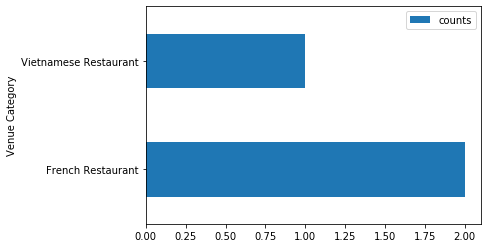

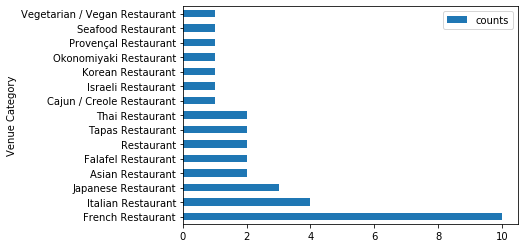

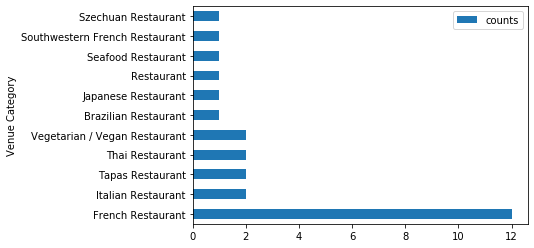

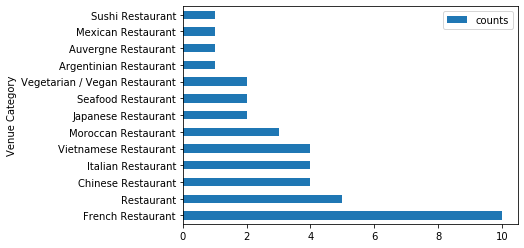

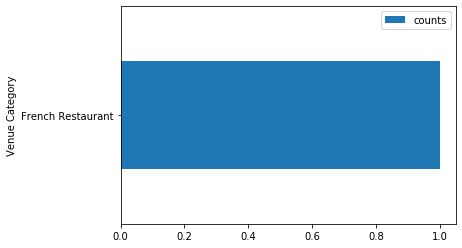

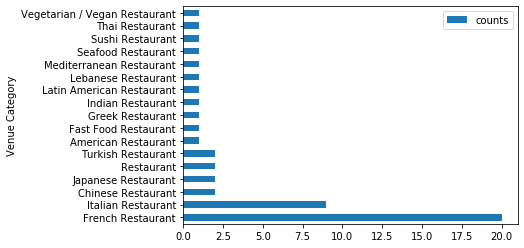

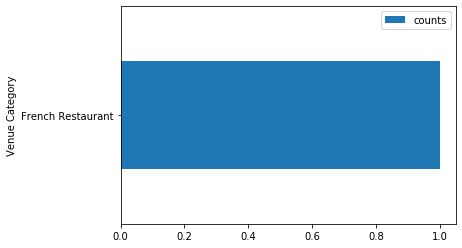

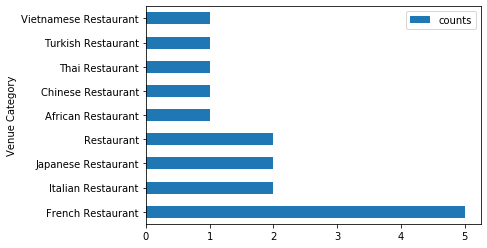

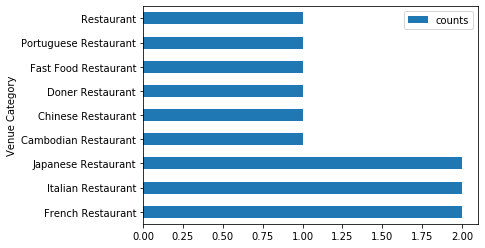

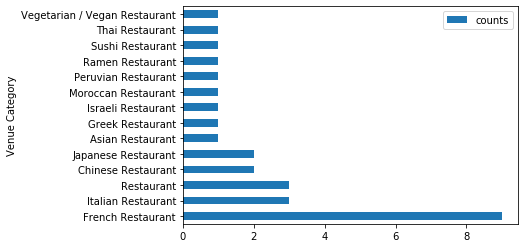

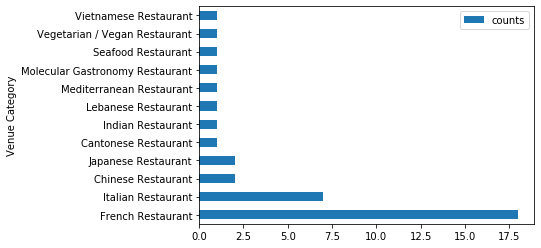

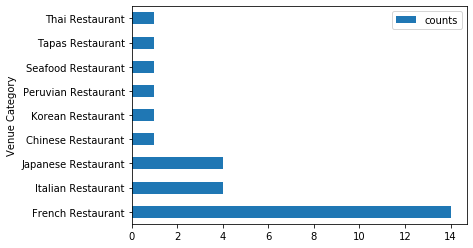

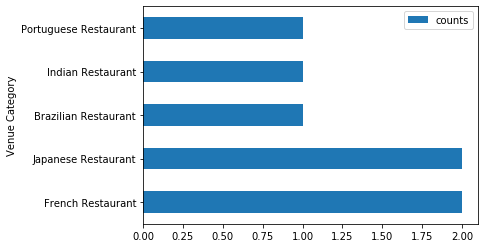

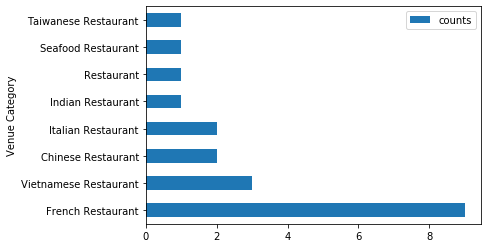

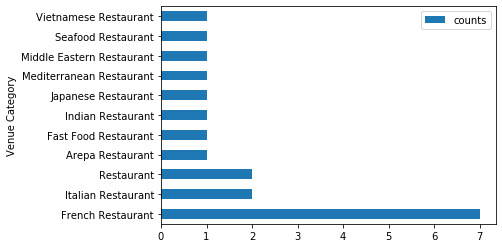

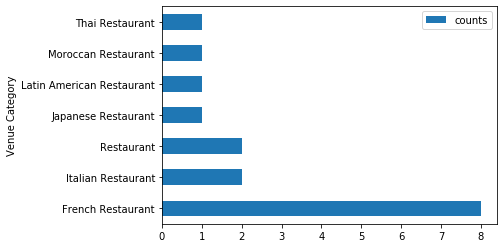

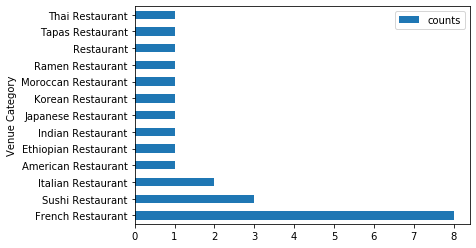

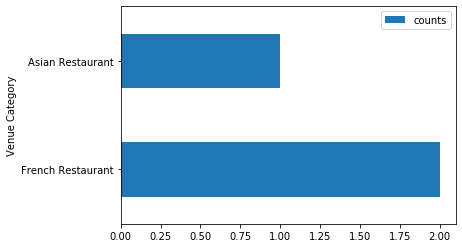

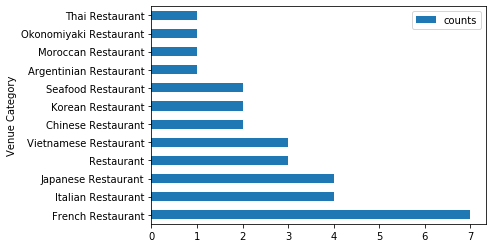

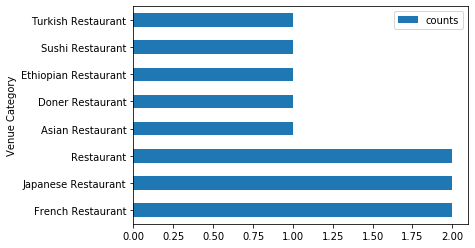

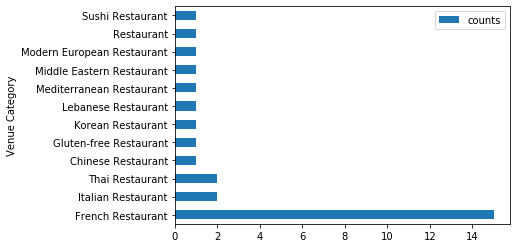

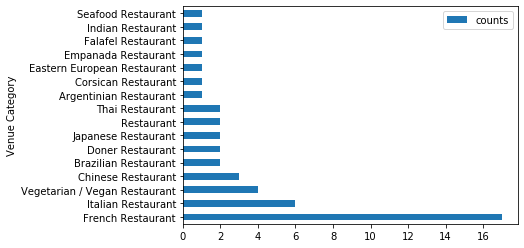

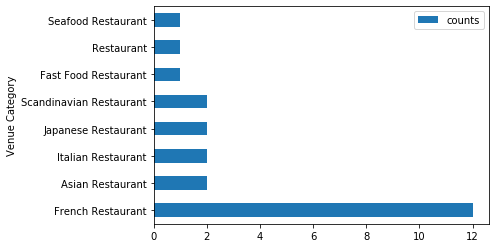

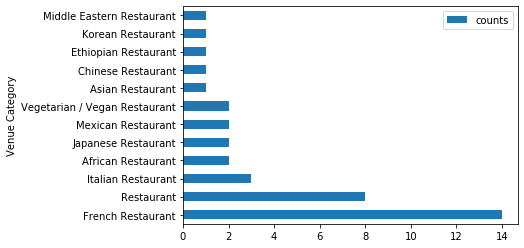

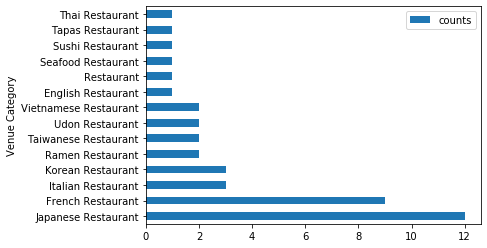

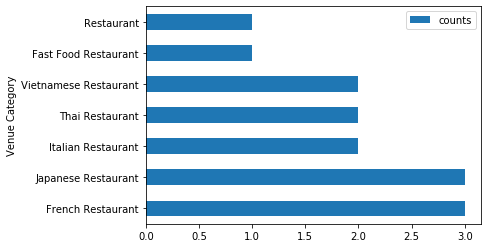

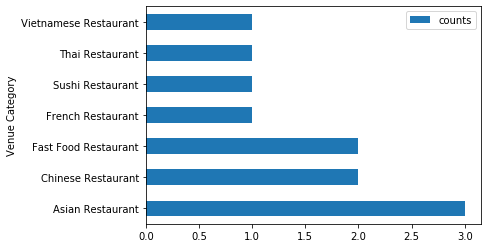

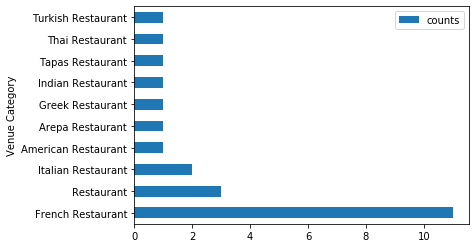

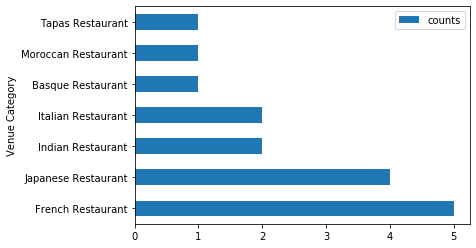

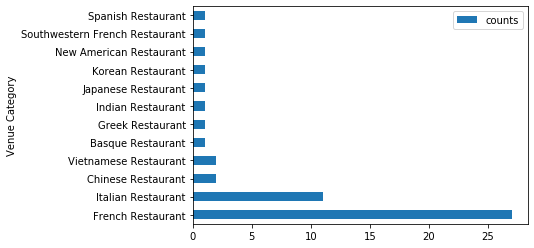

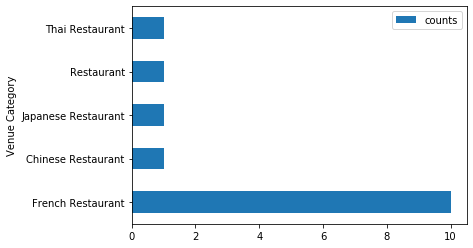

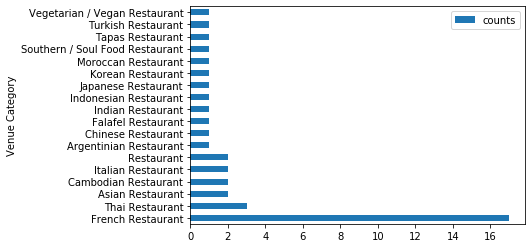

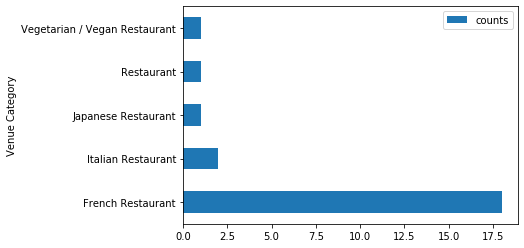

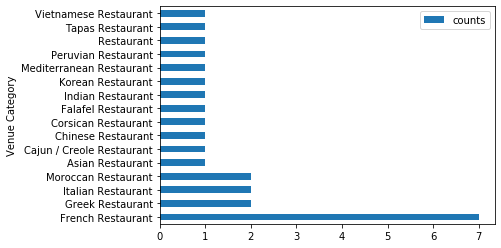

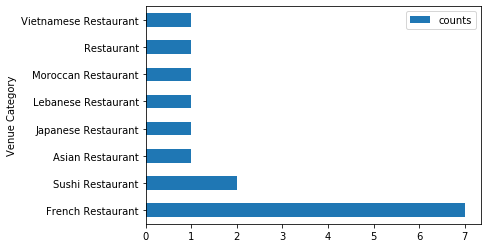

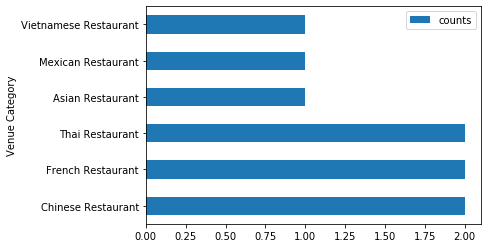

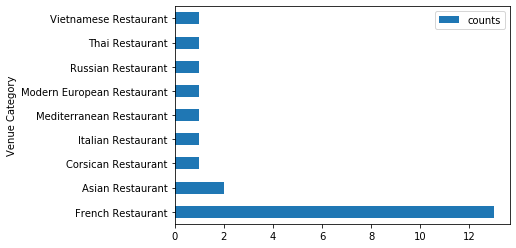

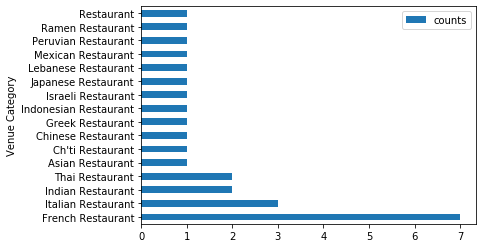

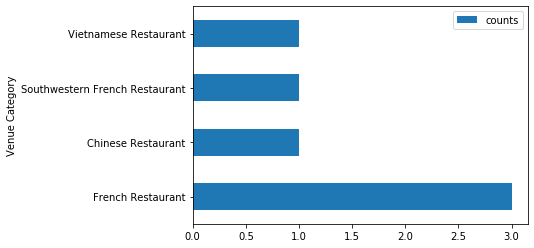

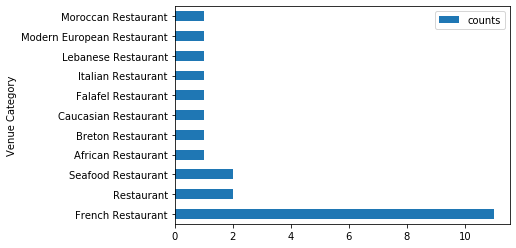

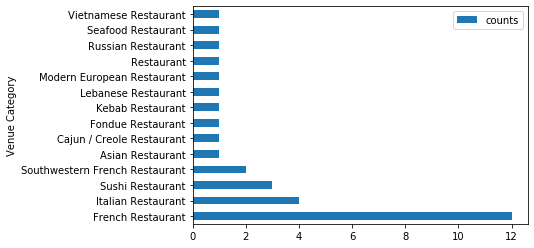

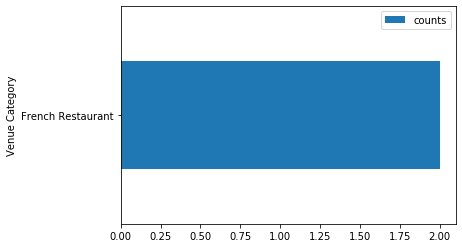

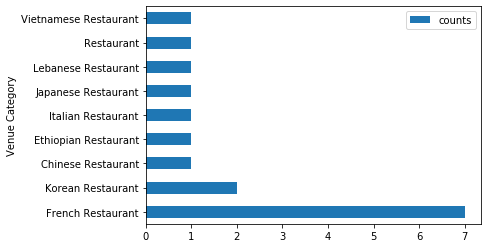

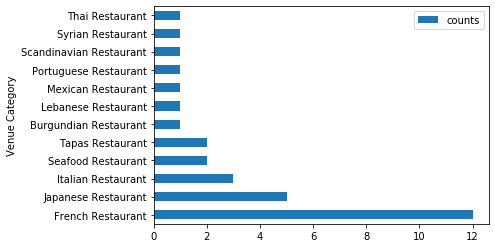

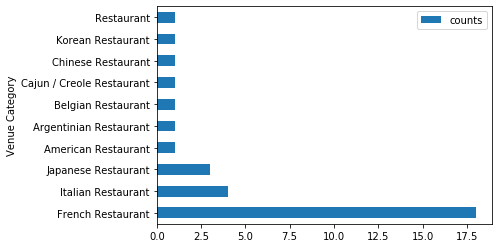

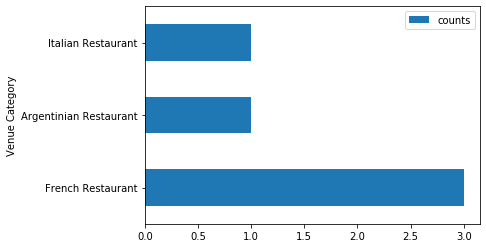

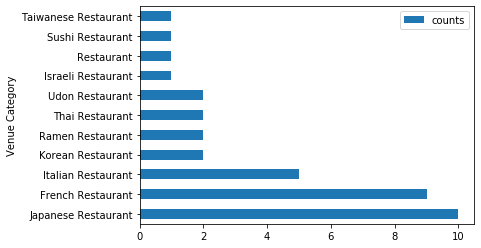

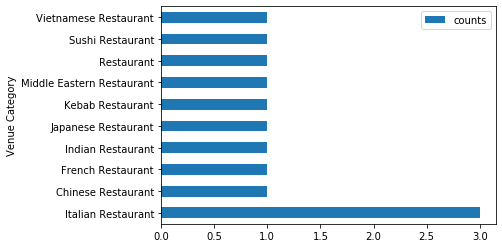

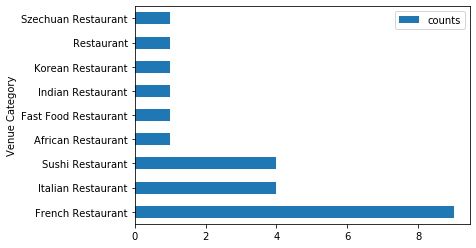

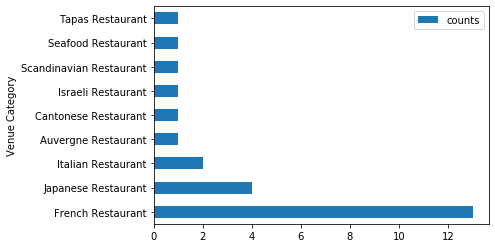

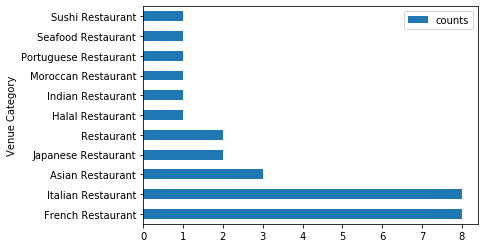

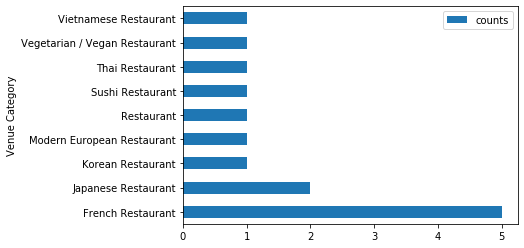

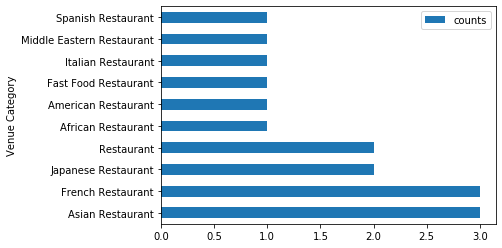

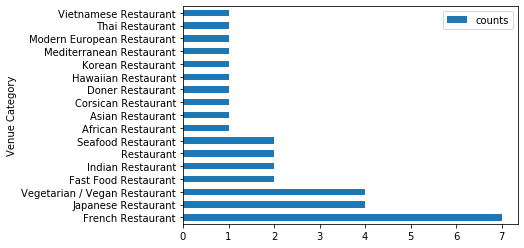

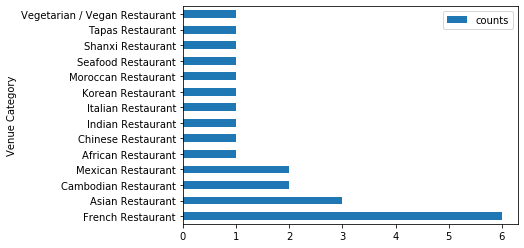

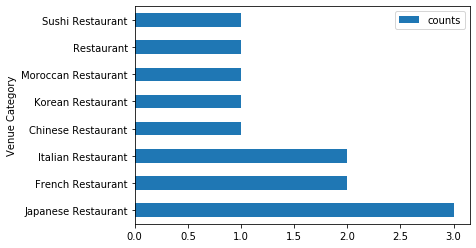

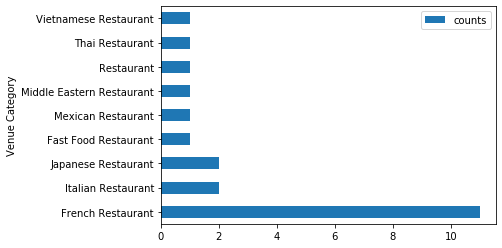

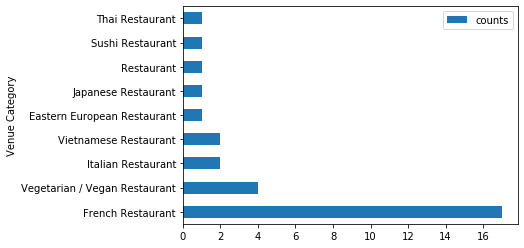

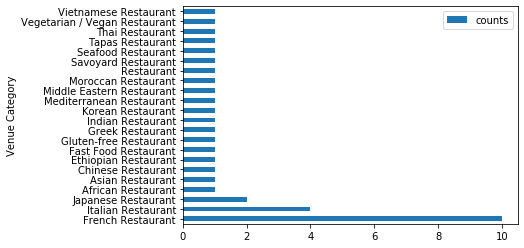

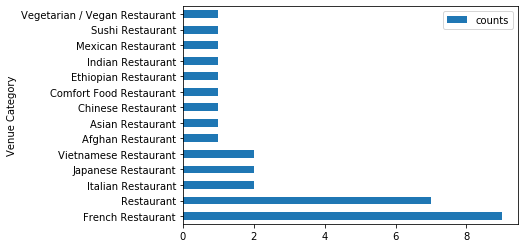

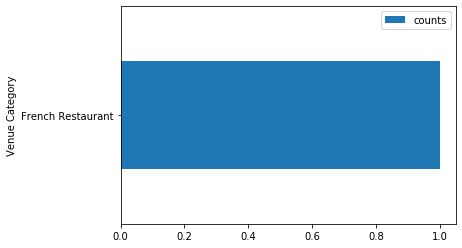

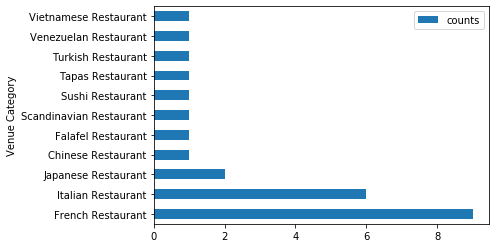

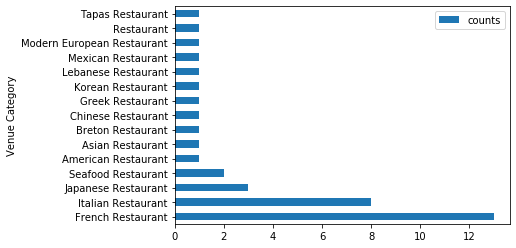

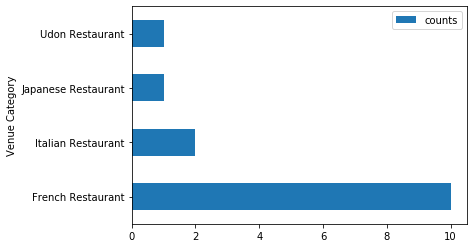

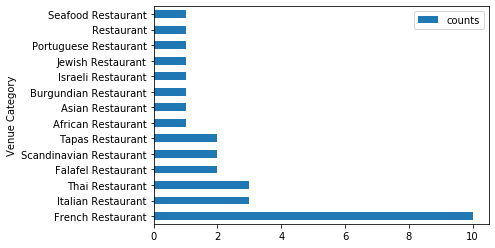

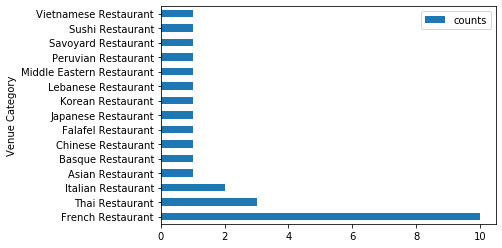

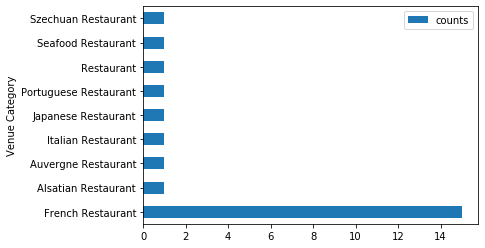

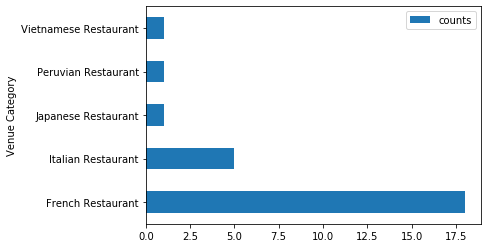

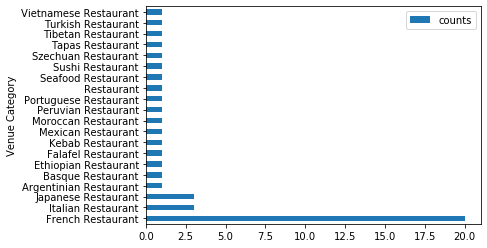

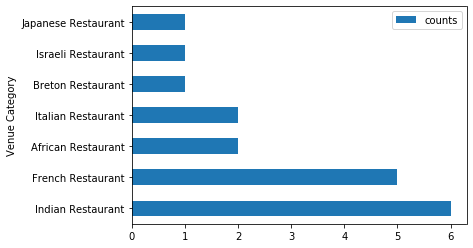

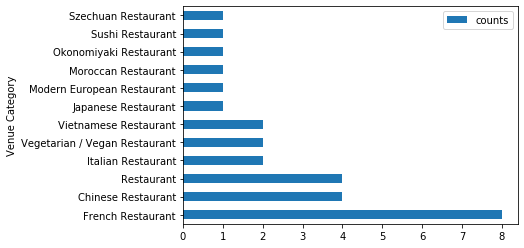

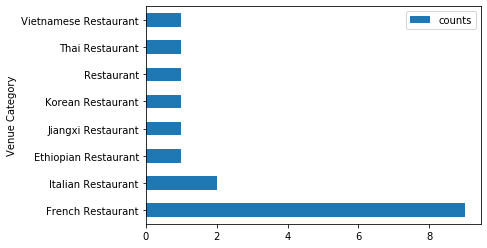

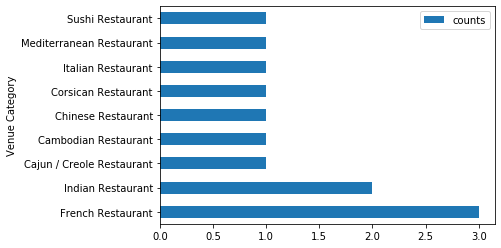

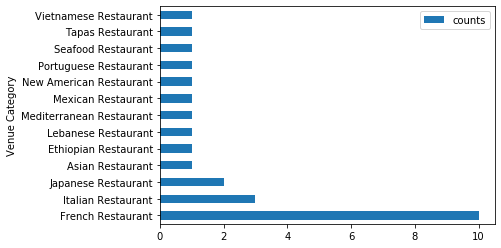

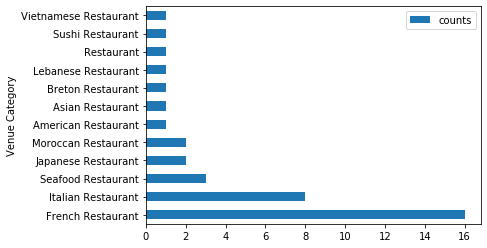

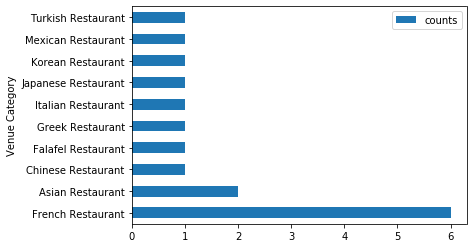

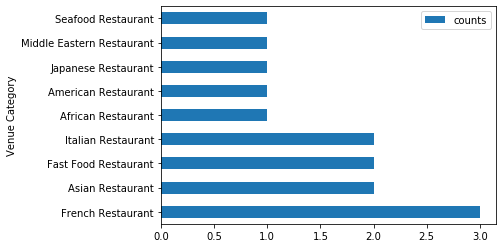

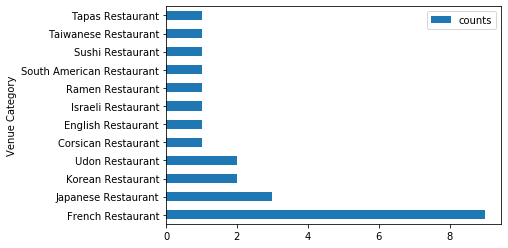

In [28]:
for i in de:
    middle = df[df['Neighborhood'] == i]
    #print(middle)
    middle.plot.barh(x = 'Venue Category', y = 'counts')
    